In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as img
from PIL import Image

In [2]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
keras.backend.clear_session()

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import os
os.chdir('/content/gdrive/My Drive/Dissertation')

In [5]:
# Load the Train and Test Directories
train_dir = '/content/gdrive/My Drive/Dissertation/Tumour/Train_crop'
test_dir  = '/content/gdrive/My Drive/Dissertation/Tumour/Test_crop'

(512, 512, 3)


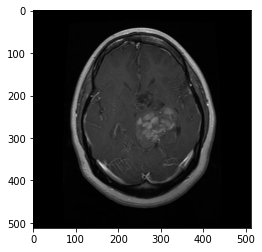

In [ ]:
# Glioma Tumor visualization
img_array = img.imread(train_dir + "/glioma_tumor/gg (1).jpg")
input_shape = img_array.shape
print(input_shape)
plt.imshow(img_array)

In [6]:
# Datagenerator for Train,Validation and Test
Generator = ImageDataGenerator(rescale = 1./255,
                              validation_split = 0.25)
#                              width_shift_range=0.2,
 #                             height_shift_range=0.2,
  #                            shear_range=0.2,
   #                           zoom_range=0.2,
    #                          rotation_range=40,horizontal_flip=True)
target_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

In [9]:
train1_generator = Generator.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                color_mode ='rgb',
                                                batch_size = 500,
                                                class_mode='categorical',
                                                classes=target_labels,
                                                subset = 'training')   
valid1_generator = Generator.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                color_mode ='rgb',
                                                batch_size = 50,
                                                class_mode = 'categorical',
                                                classes = target_labels,
                                                subset = 'validation')
test1_generator = Generator.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               color_mode='rgb',
                                               batch_size = 100,                                                
                                               class_mode = 'categorical',
                                               classes=target_labels)

Found 2155 images belonging to 4 classes.
Found 715 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [10]:
train_img,train_labels = train1_generator.next()
print(train_img.shape,train_labels.shape)
valid_img,valid_labels = valid1_generator.next()
print(valid_img.shape,valid_labels.shape)
test_img,test_labels = test1_generator.next()
print(test_img.shape,test_labels.shape)

(500, 224, 224, 3) (500, 4)
(50, 224, 224, 3) (50, 4)
(100, 224, 224, 3) (100, 4)


<h3><b>Genetic Algorithm implementation of AlexNet using pygad

In [11]:
pip install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import pygad
import pygad.gacnn

In [13]:
#Implement AlexNet architecture
inp1 = pygad.cnn.Input2D(input_shape=(224,224,3))
conv1 = pygad.cnn.Conv2D(num_filters=96,kernel_size=11,previous_layer=inp1,activation_function='relu')
maxp1 = pygad.cnn.MaxPooling2D(pool_size=2,stride=2,previous_layer=conv1)
conv2 = pygad.cnn.Conv2D(num_filters=256,kernel_size=5,previous_layer=maxp1,activation_function='relu')
maxp2 = pygad.cnn.MaxPooling2D(pool_size=2,stride=2,previous_layer=conv2)
conv3 = pygad.cnn.Conv2D(num_filters=384,kernel_size=3,previous_layer=maxp2,activation_function='relu')
conv4 = pygad.cnn.Conv2D(num_filters=384,kernel_size=3,previous_layer=conv3,activation_function='relu')
conv5 = pygad.cnn.Conv2D(num_filters=256,kernel_size=3,previous_layer=conv4,activation_function='relu')
maxp3 = pygad.cnn.MaxPooling2D(pool_size=2,stride=2,previous_layer=conv5)
flatt = pygad.cnn.Flatten(previous_layer=maxp3)
dens1 = pygad.cnn.Dense(num_neurons=4096,previous_layer=flatt,activation_function='relu')
dens2 = pygad.cnn.Dense(num_neurons=4096,previous_layer=dens1,activation_function='relu')
dens3 = pygad.cnn.Dense(num_neurons=100,previous_layer=dens2,activation_function='relu')
dens4 = pygad.cnn.Dense(num_neurons=4,previous_layer=dens3,activation_function='softmax')

In [14]:
AlexNetGA = pygad.cnn.Model(last_layer=dens4,
                        epochs=4,
                        learning_rate=0.001)

In [15]:
AlexNetGA.summary()


----------Network Architecture----------
<class 'pygad.cnn.cnn.Conv2D'>
<class 'pygad.cnn.cnn.MaxPooling2D'>
<class 'pygad.cnn.cnn.Conv2D'>
<class 'pygad.cnn.cnn.MaxPooling2D'>
<class 'pygad.cnn.cnn.Conv2D'>
<class 'pygad.cnn.cnn.Conv2D'>
<class 'pygad.cnn.cnn.Conv2D'>
<class 'pygad.cnn.cnn.MaxPooling2D'>
<class 'pygad.cnn.cnn.Flatten'>
<class 'pygad.cnn.cnn.Dense'>
<class 'pygad.cnn.cnn.Dense'>
<class 'pygad.cnn.cnn.Dense'>
<class 'pygad.cnn.cnn.Dense'>
----------------------------------------



In [16]:
GACNN_instance = pygad.gacnn.GACNN(model=AlexNetGA,
                                   num_solutions=2)

In [17]:
def fitness_func(solution, sol_idx):
    global GACNN_instance

    predictions = GACNN_instance.population_networks[sol_idx].predict(data_inputs=train_img)
    correct_predictions = np.where(predictions == train_labels)[0].size
    solution_fitness = (correct_predictions/train_labels.size)*100

    return solution_fitness

In [ ]:
population_vectors = pygad.gacnn.population_as_vectors(population_networks=GACNN_instance.population_networks)

In [ ]:
initial_population = population_vectors.copy()

In [20]:
def callback_generation(ga_instance):
    global GACNN_instance, last_fitness

    population_matrices = pygad.gacnn.population_as_matrices(population_networks=GACNN_instance.population_networks, population_vectors=ga_instance.population)

    GACNN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

In [21]:
num_parents_mating = 2
num_generations = 15
mutation_percent_genes = 0.1
parent_selection_type = "sss"
crossover_type = "single_point"
mutation_type = "random"
keep_parents = -1

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       callback_generation=callback_generation)

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:735: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


In [22]:
ga_instance.run()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """
/usr/local/lib/python3.7/dist-packages/pygad/cnn/cnn.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array(network_weights)


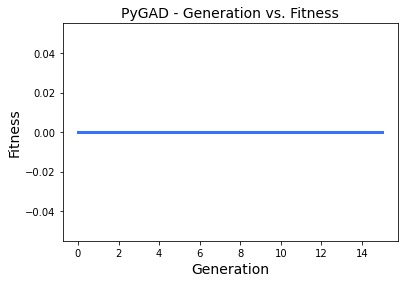

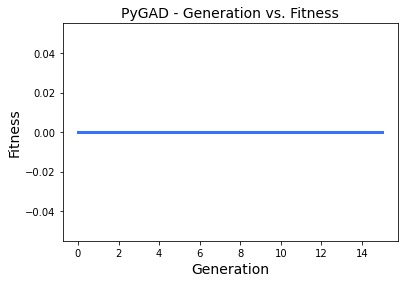

In [23]:
ga_instance.plot_fitness()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

In [ ]:
predictions = pygad.cnn.predict(last_layer=GANN_instance.population_networks[solution_idx], data_inputs=data_inputs)
print("Predictions of the trained network : {predictions}".format(predictions=predictions))